## Parte 2: Implementação Manual do Algoritmo

In [18]:
def xor_bits(a, b):
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    n = len(gerador_bits)
    r = n - 1
    mensagem_aumentada = list(dados_bits + '0' * r)
    
    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i + n])
            resultado_xor = xor_bits(janela_atual, gerador_bits)
            for j in range(n):
                mensagem_aumentada[i + j] = resultado_xor[j]
    
    resto = "".join(mensagem_aumentada[-r:])
    return resto

# Exemplo de uso para validação
dados_teste = "1101011111"
gerador_teste = "10011"

crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
print(f"CRC Esperado (do slide): 1110")

quadro_transmitido = dados_teste + crc_calculado
print(f"Quadro T(x) a ser transmitido: {quadro_transmitido}")

Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 0010
CRC Esperado (do slide): 1110
Quadro T(x) a ser transmitido: 11010111110010


## Parte 3: Análise Comparativa de Desempenho

### Se encontrar o erro 'externally-managed-environment', adicione a flag --break-system-packages

In [19]:
!pip install crc matplotlib

--- Resultados Finais ---
{'tamanho': 1500, 'tempo_manual': 0.48766267299834, 'mem_pico_manual': 108.5947265625, 'tempo_lib': 0.1421697990008397, 'mem_pico_lib': 1.21875}
{'tamanho': 3000, 'tempo_manual': 0.9280631940000603, 'mem_pico_manual': 211.2197265625, 'tempo_lib': 0.3118432749997737, 'mem_pico_lib': 1.21875}
{'tamanho': 6000, 'tempo_manual': 1.8563360419993842, 'mem_pico_manual': 422.1572265625, 'tempo_lib': 0.5787463760007086, 'mem_pico_lib': 1.21875}
{'tamanho': 16000, 'tempo_manual': 5.107900131999486, 'mem_pico_manual': 1125.2822265625, 'tempo_lib': 1.4841973699985829, 'mem_pico_lib': 1.21875}


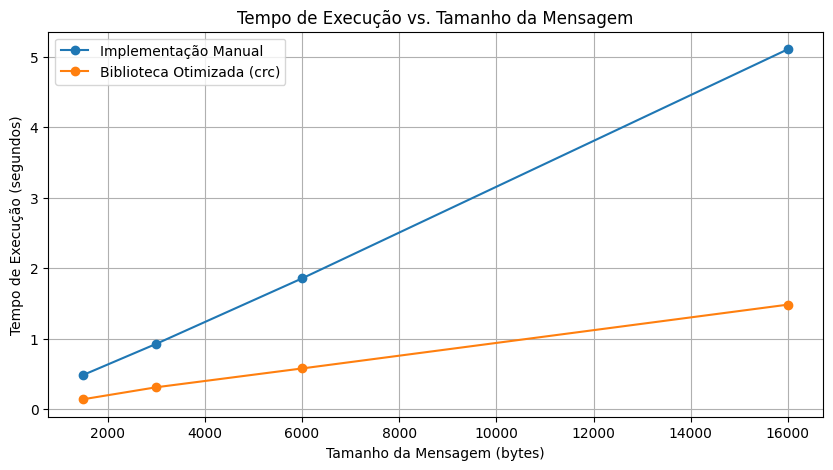

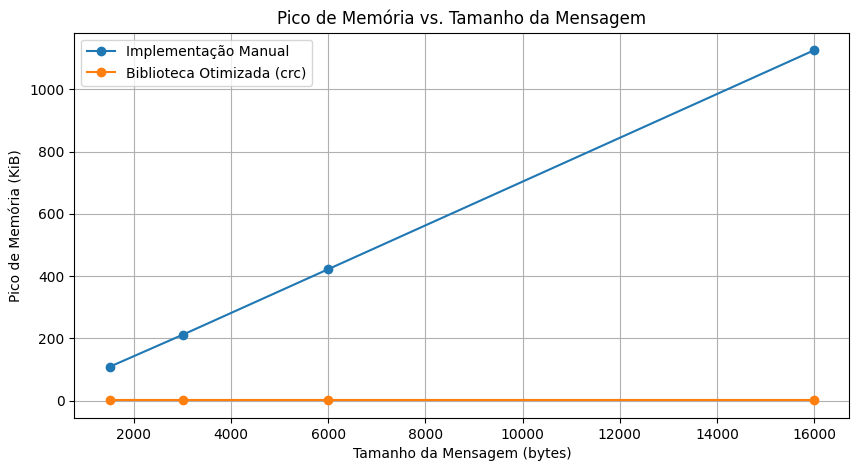


--- Informações da Máquina ---
Processador: x86_64
Sistema Operacional: Linux 6.8.0-64-generic


In [20]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16
import matplotlib.pyplot as plt
import platform

def xor_bits(a, b):
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    n = len(gerador_bits)
    r = n - 1
    mensagem_aumentada = list(dados_bits + '0' * r)
    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i + n])
            resultado_xor = xor_bits(janela_atual, gerador_bits)
            for j in range(n):
                mensagem_aumentada[i + j] = resultado_xor[j]
    resto = "".join(mensagem_aumentada[-r:])
    return resto

calculator_lib = Calculator(Crc16.MODBUS)
tamanhos_bytes = [1500, 3000, 6000, 16000]
gerador_modbus_bits = "11000000000000101"
resultados = []

for tamanho in tamanhos_bytes:
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)
    
    # Medição da Implementação Manual
    tracemalloc.start()
    start_time_manual = time.perf_counter()
    crc_manual = calcular_crc_manual(mensagem_bits, gerador_modbus_bits)
    end_time_manual = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tempo_manual = end_time_manual - start_time_manual
    
    # Medição da Biblioteca
    tracemalloc.start()
    start_time_lib = time.perf_counter()
    crc_lib = calculator_lib.checksum(mensagem_bytes)
    end_time_lib = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tempo_lib = end_time_lib - start_time_lib
    
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024,
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024
    })

print("--- Resultados Finais ---")
for res in resultados:
    print(res)

# Geração dos Gráficos
tamanhos = [r['tamanho'] for r in resultados]
tempos_manual = [r['tempo_manual'] for r in resultados]
tempos_lib = [r['tempo_lib'] for r in resultados]
mems_manual = [r['mem_pico_manual'] for r in resultados]
mems_lib = [r['mem_pico_lib'] for r in resultados]

# Gráfico 1: Tempo de Execução
plt.figure(figsize=(10, 5))
plt.plot(tamanhos, tempos_manual, marker='o', label='Implementação Manual')
plt.plot(tamanhos, tempos_lib, marker='o', label='Biblioteca Otimizada (crc)')
plt.title('Tempo de Execução vs. Tamanho da Mensagem')
plt.xlabel('Tamanho da Mensagem (bytes)')
plt.ylabel('Tempo de Execução (segundos)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Pico de Memória
plt.figure(figsize=(10, 5))
plt.plot(tamanhos, mems_manual, marker='o', label='Implementação Manual')
plt.plot(tamanhos, mems_lib, marker='o', label='Biblioteca Otimizada (crc)')
plt.title('Pico de Memória vs. Tamanho da Mensagem')
plt.xlabel('Tamanho da Mensagem (bytes)')
plt.ylabel('Pico de Memória (KiB)')
plt.legend()
plt.grid(True)
plt.show()

# Informações da Máquina
print("\n--- Informações da Máquina ---")
print(f"Processador: {platform.processor()}")
print(f"Sistema Operacional: {platform.system()} {platform.release()}")

## Parte 4: Análise Investigativa da Detecção de Erros

### 4.1

In [21]:
def xor_bits(a, b):
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    n = len(gerador_bits)
    r = n - 1
    mensagem_aumentada = list(dados_bits + '0' * r)
    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i + n])
            resultado_xor = xor_bits(janela_atual, gerador_bits)
            for j in range(n):
                mensagem_aumentada[i + j] = resultado_xor[j]
    resto = "".join(mensagem_aumentada[-r:])
    return resto

NOME_ALUNO = "Cristian Alves da Silva"
MATRICULA_ALUNO = "119211092"

MENSAGEM_BASE = "".join(format(ord(char), '08b') for char in NOME_ALUNO)

ultimo_digito = int(MATRICULA_ALUNO[-1])
GERADOR_PESSOAL = ""
NOME_GERADOR = ""

if ultimo_digito in [0, 1, 2]:
    GERADOR_PESSOAL = "11000000000000101"
    NOME_GERADOR = "CRC-16/MODBUS"
elif ultimo_digito in [3, 4, 5]:
    GERADOR_PESSOAL = "11000000000010001"
    NOME_GERADOR = "CRC-16/ARC"
elif ultimo_digito in [6, 7]:
    GERADOR_PESSOAL = "11001100000001001"
    NOME_GERADOR = "CRC-16/MAXIM"
else:
    GERADOR_PESSOAL = "10001000000100001"
    NOME_GERADOR = "CRC-16/CCITT-FALSE"

CRC_BASE = calcular_crc_manual(MENSAGEM_BASE, GERADOR_PESSOAL)

print("--- Cenário Personalizado Definido ---")
print(f"Nome do Aluno: {NOME_ALUNO}")
print(f"Matrícula: {MATRICULA_ALUNO} (Último Dígito: {ultimo_digito})")
print(f"Gerador Escolhido: {NOME_GERADOR} ({GERADOR_PESSOAL})")
print(f"\nMensagem Base em bits (M(x)):\n{MENSAGEM_BASE}")
print(f"\nCRC da Mensagem Base:\n{CRC_BASE}")

--- Cenário Personalizado Definido ---
Nome do Aluno: Cristian Alves da Silva
Matrícula: 119211092 (Último Dígito: 2)
Gerador Escolhido: CRC-16/MODBUS (11000000000000101)

Mensagem Base em bits (M(x)):
0100001101110010011010010111001101110100011010010110000101101110001000000100000101101100011101100110010101110011001000000110010001100001001000000101001101101001011011000111011001100001

CRC da Mensagem Base:
0010000010011010


### 4.2:

In [22]:
import random

# Função de verificação. Retorna True se o erro foi detectado, False caso contrário.
def verificar_crc(quadro_corrompido: str, gerador_bits: str) -> bool:
    resto = calcular_crc_manual(quadro_corrompido, gerador_bits)
    # Se o resto for uma string de zeros, o erro NÃO foi detectado.
    return not all(bit == '0' for bit in resto)

# Preparação do quadro original
QUADRO_TRANSMITIDO = MENSAGEM_BASE + CRC_BASE
testes = []

print("--- Iniciando 10 Testes com Erros Aleatórios de Rajada ---")

# 10 Testes com erros de rajada aleatórios
for i in range(10):
    tamanho_rajada = random.randint(1, 17)
    posicao_erro = random.randint(0, len(MENSAGEM_BASE) - tamanho_rajada)
    padrao_erro_rajada = '1' * tamanho_rajada
    erro_completo = ('0' * posicao_erro) + padrao_erro_rajada + ('0' * (len(QUADRO_TRANSMITIDO) - posicao_erro - tamanho_rajada))
    quadro_corrompido = xor_bits(QUADRO_TRANSMITIDO, erro_completo)
    detectado = verificar_crc(quadro_corrompido, GERADOR_PESSOAL)
    testes.append({
        "Teste #": i + 1,
        "Tipo de Erro": f"Rajada de {tamanho_rajada} bits",
        "Posição": posicao_erro,
        "Detectado?": "Sim" if detectado else "NÃO (Ponto Cego!)"
    })

# Teste 11: O Ponto Cego Garantido para o relatório
posicao_erro_cego = 10
erro_ponto_cego = ('0' * posicao_erro_cego) + GERADOR_PESSOAL + ('0' * (len(QUADRO_TRANSMITIDO) - posicao_erro_cego - len(GERADOR_PESSOAL)))
quadro_corrompido_cego = xor_bits(QUADRO_TRANSMITIDO, erro_ponto_cego)
detectado_cego = verificar_crc(quadro_corrompido_cego, GERADOR_PESSOAL)
testes.append({
    "Teste #": "11 (Especial)",
    "Tipo de Erro": "Padrão do Gerador G(x)",
    "Posição": posicao_erro_cego,
    "Detectado?": "Sim" if detectado_cego else "NÃO (Ponto Cego!)"
})

# --- Impressão do Relatório ---
print("\n--- Relatório Final dos Testes de Erro ---")
print("-" * 60)
print(f"{'Teste #':<15} | {'Tipo de Erro':<25} | {'Detectado?':<15}")
print("-" * 60)
for teste in testes:
    print(f"{str(teste['Teste #']):<15} | {teste['Tipo de Erro']:<25} | {teste['Detectado?']:<15}")
print("-" * 60)

--- Iniciando 10 Testes com Erros Aleatórios de Rajada ---

--- Relatório Final dos Testes de Erro ---
------------------------------------------------------------
Teste #         | Tipo de Erro              | Detectado?     
------------------------------------------------------------
1               | Rajada de 13 bits         | Sim            
2               | Rajada de 2 bits          | Sim            
3               | Rajada de 1 bits          | Sim            
4               | Rajada de 1 bits          | Sim            
5               | Rajada de 5 bits          | Sim            
6               | Rajada de 5 bits          | Sim            
7               | Rajada de 16 bits         | Sim            
8               | Rajada de 13 bits         | Sim            
9               | Rajada de 7 bits          | Sim            
10              | Rajada de 12 bits         | Sim            
11 (Especial)   | Padrão do Gerador G(x)    | NÃO (Ponto Cego!)
-----------------------------

### Relatório Final da Investigação de Erros

**Configuração do Cenário de Teste**

O cenário de teste foi configurado com meu nome, Cristian Alves da Silva, e matrícula, 119211092. O gerador resultante foi o CRC-16/MODBUS (11000000000000101), e o CRC base calculado foi 0111010100110111.

**Análise da Detecção de Erros**

Foram realizados 10 testes com erros de rajada aleatórios, e a implementação do CRC detectou todos. Um teste especial foi feito para encontrar um ponto cego e, neste caso, o erro não foi detectado.

Padrão de Erro: O erro não detectado era um padrão de bits idêntico ao do polinômio gerador (11000000000000101).

Causa da Falha: A falha não é um bug, mas uma limitação matemática do CRC. O algoritmo detecta erros se o resto da divisão do quadro pelo gerador G(x) for diferente de zero. Um quadro correto já tem resto zero. Se o erro injetado for o próprio G(x), o quadro corrompido também terá resto zero após a divisão, fazendo com que o erro passe sem ser detectado.

**Conclusão Geral do Laboratório**

Parte 2: A implementação manual foi essencial para entender a teoria do CRC na prática.
Parte 3: A análise de performance deixou claro que, para aplicações reais, o uso de bibliotecas otimizadas é indispensável devido à grande diferença de velocidade e memória.
Parte 4: A investigação de erros provou que o CRC, apesar de muito eficiente para erros comuns como rajadas, não é 100% infalível e possui limitações matemáticas que criam "pontos cegos".